# Ekologická inference a Sankey graf

Možná jste viděli graf, jak se přesouvají voliči stran. Ráda bych, abyste podobný graf zpracovali pro předposlední a poslední volby.

Jde o to, že pro jednotlivé volební okrsky budete mít dva typy informací: jednak procenta hlasů stranám v minulých volbách, jednak procenta v současných volbách.

V příkladu zde jde o procenta národnostního složení a procenta volebních preferencí.

Nejdříve pomocí Ekologické Infernce najdeme model, který 'spáruje' jednu a druhou kategorii podle maximálně věrohodných parametrů $\beta$ lineání regrese, ze kterých pak vypočte 'procenta' hlasů v nových volbách pro jednotlivé třídy voleb minulých (národnostní skupiny).

Výsledek zobrazíme Sankey grafem.

In [1]:
import pandas as pd

VERBOSE=False

v2017=pd.read_csv('https://ktiml.mff.cuni.cz/~marta/volby2017.csv',sep='\t',encoding='cp1250')
v2021=pd.read_csv('https://ktiml.mff.cuni.cz/~marta/volby2021.csv',sep='\t',encoding='cp1250')
nazvy=pd.read_csv('https://ktiml.mff.cuni.cz/~marta/kraje.csv',sep='\t',encoding='cp1250')[2:]

if VERBOSE:
    print(v2017.head(1))
    print(v2021.head(1))
    print(nazvy.head(1))    

## Spouštím na https://colab.research.google.com/drive/

kde musím instalovat knihovny ... ale funguje to.

In [2]:
#! pip install pyei
#!pip install plotly
import numpy as np
import pymc3 as pm

from pyei.data import Datasets
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Příprava dat

součet po skupinách stran

In [3]:
mat17=v2017.groupby('skupina').sum()
mat21=v2021.groupby('skupina').sum()

výpočet procent pro strany z voličů kraje

In [4]:
fract17=(mat17/mat17.sum())
fract21=(mat21/mat21.sum())

In [5]:
hist=pd.DataFrame({'17':mat17.sum(axis=1),'21':mat21.sum(axis=1),'dif':mat21.sum(axis=1)-mat17.sum(axis=1)})

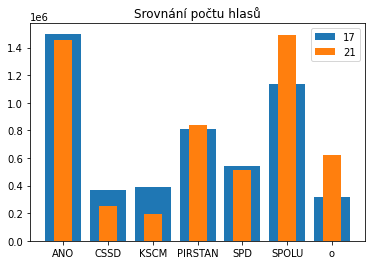

In [6]:
import matplotlib.pyplot as plt
plt.bar(hist.index,hist['17'],label='17')
plt.bar(hist.index,hist['21'],label='21',width=0.4)
plt.title('Srovnání počtu hlasů')
plt.legend()

### a učíme model

In [7]:
# Fitting a first r x c model

# Create a RowByColumnEI object
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)#,chains=1, draws, tune =number_of_iterations

# Fit the model
ei_rbyc.fit(np.array(fract17), 
       np.array(fract21), 
       mat21.sum().values, 
       demographic_group_names=mat21.index.values, 
       candidate_names=mat17.index.values, 
       precinct_names=nazvy['nazev_polozky'].values, 
)

# Generate a simple report to summarize the results
#print(ei_rbyc.summary())

Running ['ANO' 'CSSD' 'KSCM' 'PIRSTAN' 'SPD' 'SPOLU' 'o'] x ['ANO' 'CSSD' 'KSCM' 'PIRSTAN' 'SPD' 'SPOLU' 'o'] EI
r = 7 rows (demographic groups)
c = 7 columns (candidates or voting outcomes)
number of precincts = 14


C:\Users\marta\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\marta\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, phi, kappa]


ValueError: Not enough samples to build a trace.

výsledky uložíme do proměnné

In [ ]:
VERBOSE=True
results=ei_rbyc.posterior_mean_voting_prefs
if VERBOSE:  print(np.round(results,2))

[[0.74437741 0.02060759 0.01204607 0.04626478 0.04517217 0.04944208
  0.08208989]
 [0.18523556 0.27674809 0.08777707 0.03377722 0.04196027 0.09804179
  0.27645999]
 [0.17273664 0.03733284 0.17669285 0.05679345 0.16069363 0.11481611
  0.28093448]
 [0.02651937 0.02921823 0.01675794 0.69715252 0.02706238 0.13953013
  0.06375943]
 [0.11289595 0.0355412  0.03966635 0.04021862 0.51987973 0.05541838
  0.19637977]
 [0.01878484 0.02867107 0.00728543 0.03415728 0.01343131 0.87056538
  0.0271047 ]
 [0.04714774 0.04107342 0.06103877 0.20165539 0.06254738 0.38933517
  0.19720213]]

Příprava grafu

počet různých volebních skupin

In [ ]:
n_types=mat21.shape[0]

Hrany vedou ze source do target; sources začínají všemi 'odchody' z jedné skupiny

In [ ]:
source0=[[i]*n_types for i in range(n_types)]
source=source=np.array(source0).ravel()

target se střídají konce hran, navíc cílové uzly jsou zadní, tj. od indexu n_types.

In [ ]:
target=list(range(n_types,n_types*2))*n_types

## A jdeme na graf

jen co připravíme barvy a načteme knihovnu

In [ ]:
import plotly.express as px
my_colors=px.colors.qualitative.Light24
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = list(mat17.index.values)+list(mat21.index.values),
      color = my_colors[:n_types]+my_colors[:n_types],
    ),
    link = dict(
      source = source, 
      target = target,
      value = results.ravel(),
      color = np.array([[my_colors[i]]*n_types for i in range(n_types)]).ravel(),
  ))])

fig.update_layout(title_text="Odhadovaný přesun voličů 2017 - 2021", font_size=10)
fig.show()

totéž, jen jsou stejné barvy příchozí hrany.

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = list(mat17.index.values)+list(mat21.index.values),
      color = my_colors[:n_types]+my_colors[:n_types],
    ),
    link = dict(
      source = source, 
      target = target,
      value = results.ravel(),
      color = my_colors[:n_types]*n_types,
  ))])

fig.update_layout(title_text="Odhadovaný přesun voličů 2017 - 2021", font_size=10)
fig.show()